In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from celluloid import Camera
from matplotlib.backend_bases import FigureCanvasBase
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import timeit

from src.environment_old import LogEnv_old
from src.utils import path_distance_new, check_missing_vertexes_jampr

from src.or_functions import compute_distance

#from src.environment import LogEnv
#from src.train import train
#from src.architecture import AttentionModel
#from src.evaluation import compute_mean_metric, compute_data_metric, compute_mean_metric_with_or
#from src.vizualisation import demonstration, action_animation
from src.environment_jampr import LogEnv
from src.architecture_jampr_2 import AttentionModel
from src.train_jampr import train
from src.or_functions_jampr import compute_distance
from src.evaluation_jampr import compute_mean_metric, compute_mean_metric_with_or
from src.vizualisation_jampr import demonstration, env_plot

import GPUtil
from pytorch_memlab import LineProfiler, MemReporter

## Отладка

In [ ]:
env = LogEnv(n=50, batch_size=128, active_num=1, K=20)
env.reset()
'a'

In [ ]:
model = AttentionModel(active_num=1).to('cuda')
#model.eval()
'a'
#model.load_state_dict(weights)

In [ ]:
features, _, mask = env.reset(full_reset=False)
print(mask)
print(env.pairs)
print(features[0][:, :, 3:5])
print(features[0][:, :, 2])
flag = False
while not flag:
    v1 = int(input())
    v2 = int(input())
    v = torch.tensor([v1, v2]).view(1, -1)
    v1 = int(input())
    v2 = int(input())
    v_m = torch.tensor([v1, v2]).view(1, -1)
    v = torch.cat([v, v_m], dim=0)
    print(v)
    #print(d[0, v[0, 1], :])
    features, mask, flag = env.step(v)
    features = list(map(lambda x: x.to('cuda'), features))
    print(mask)
    print(flag)
print(env.tour_plan)
print(features[2][:, :, 4].sum().to('cpu') + check_missing_vertexes_jampr(env.tour_plan, problem_size) * 10000)

#20 -> 13 -> 2 -> 16 -> 18 -> 15 -> 14 -> 3
#9 -> 1 -> 17 -> 10 -> 7 -> 8
#19 -> 12 -> 5 -> 11 -> 6 -> 4


#17 -> 9 -> 7 -> 1 -> 19 -> 12 -> 11 -> 6
#13 -> 3
#2 -> 15
#20 -> 5 -> 4 -> 14
#10 -> 8 -> 16 -> 18

In [ ]:
device = 'cuda'

In [ ]:
problem_size = 50

In [ ]:
#env = LogEnv(n=20, batch_size=2, active_num=1)
features, d, mask = env.reset()#full_reset=False)
#print(mask)
#print(env.pairs)
#print(features[0][:, :, 3:5])
features = list(map(lambda x: None if x is None else x.to(device), features))
flag = False
t = 0
precomputed = None
with LineProfiler(model.forward) as prof:
    while not flag:
        v, p, precomputed = model.forward(features, mask, t, precomputed, sample=False)
        t = t + 1
        v = v.to('cpu')
        #print(v, p)
        #print(d[0, v[0, 1], :])
        features, mask, flag = env.step(v)
        features = list(map(lambda x: None if x is None else x.to(device), features))
        #print(flag)
        #print(mask)
    #print(env.tour_plan)
    #print(features[2][:, :, 4].sum(dim=1).to('cpu') + check_missing_vertexes_jampr(env.tour_plan, problem_size) * 1000)


#20 -> 13 -> 2 -> 16 -> 18 -> 15 -> 14 -> 3
#9 -> 1 -> 17 -> 10 -> 7 -> 8
#19 -> 12 -> 5 -> 11 -> 6 -> 4

In [ ]:
prof.display()

In [ ]:
reporter = MemReporter()

In [ ]:
reporter.report()

In [ ]:
reporter.report()

In [ ]:
GPUtil.showUtilization()

In [ ]:
data = {}
data['time_matrix'] = env.distance.numpy()[0].squeeze()
data['num_vehicles'] = 10
data['time_windows'] = env.tw.numpy()[0].squeeze()
data['demands'] = env.demand.numpy()[0].squeeze()*env.capacity
data['vehicle_capacities'] = [env.capacity]*data['num_vehicles']
data['pickups_deliveries'] = env.pairs
compute_distance(data, eps=1e-2, time_limit=0.5)

In [ ]:
float()

In [ ]:
data = {}
data['time_matrix'] = env.distance.numpy()[1].squeeze()
data['num_vehicles'] = 10
data['time_windows'] = env.tw.numpy()[1].squeeze()
data['demands'] = env.demand.numpy()[1].squeeze()*env.capacity
data['vehicle_capacities'] = [env.capacity]*data['num_vehicles']
data['pickups_deliveries'] = env.pairs
compute_distance(data, eps=1e-2, time_limit=1)

## Обучение

In [3]:
model = AttentionModel(active_num=1)
model = model.to('cuda')

In [4]:
%%time
weights, _, _, _, _ = train(model, device="cuda", problem_size=120, num_vehicles=20,
                            batch_size=64, epochs=100, T=10, lr=1e-4, decay=0.001)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

tensor(157675.4219)
| ID | GPU | MEM |
------------------
|  0 | 80% | 66% |
tensor(158988.7969)
| ID | GPU | MEM |
------------------
|  0 | 78% | 66% |
tensor(169115.1875)
| ID | GPU | MEM |
------------------
|  0 | 78% | 66% |
tensor(172736.1562)
| ID | GPU | MEM |
------------------
|  0 | 76% | 66% |
tensor(100231.4219)
| ID | GPU | MEM |
------------------
|  0 | 73% | 70% |
tensor(131164.8125)
| ID | GPU | MEM |
------------------
|  0 | 76% | 70% |
tensor(101156.1562)
| ID | GPU | MEM |
------------------
|  0 | 76% | 70% |
tensor(102512.0938)
| ID | GPU | MEM |
------------------
|  0 | 77% | 70% |
tensor(107372.1641)
| ID | GPU | MEM |
------------------
|  0 | 81% | 70% |
tensor(110619.8359)


  1%|▊                                                                                 | 1/100 [00:35<58:08, 35.24s/it]

| ID | GPU | MEM |
------------------
|  0 | 78% | 70% |
tensor([[ 72, 120],
        [  5,  35],
        [ 54,  52],
        [ 49,  85],
        [ 19,  58],
        [ 38,  30],
        [ 82,  70],
        [104,  60],
        [ 34,  53],
        [ 17,  29],
        [105, 119],
        [ 71,  31],
        [ 90,  22],
        [ 80,  20],
        [ 28,  16],
        [ 66,  36],
        [112,   8],
        [  2,   3],
        [109, 113],
        [ 26,  48],
        [ 87,  10],
        [ 44, 118],
        [  7,  27],
        [ 95,  14],
        [ 24, 101],
        [117,  89],
        [ 67,  40],
        [ 37,  59],
        [ 63,  86],
        [ 77,  21],
        [ 42,  47],
        [ 74,  88],
        [102,  43],
        [ 51,  13],
        [ 65,  91],
        [ 84,  92],
        [103,  33],
        [ 69,  50],
        [106,  64],
        [ 18, 100],
        [ 15,  79],
        [ 73,  93],
        [ 78,   4],
        [  1,   9],
        [ 99,  55],
        [ 94,  32],
        [110,  68],
   

  2%|█▋                                                                                | 2/100 [01:10<57:29, 35.20s/it]

| ID | GPU | MEM |
------------------
|  0 | 76% | 70% |
tensor([[  5,  21],
        [ 86,  64],
        [ 63,  71],
        [  4, 115],
        [ 57,  62],
        [ 99,  43],
        [ 60,  50],
        [101,  56],
        [ 83,  52],
        [112,  32],
        [ 94,  93],
        [  3, 108],
        [ 80,  97],
        [ 10, 119],
        [110,  45],
        [ 26,  19],
        [102,  20],
        [ 42,   7],
        [107,  59],
        [ 78,  30],
        [117,  14],
        [105,  77],
        [ 44,  91],
        [ 12,   9],
        [ 85, 116],
        [ 38,  74],
        [ 87,  79],
        [ 95,  89],
        [106,  17],
        [ 58, 103],
        [ 23,  22],
        [104,  39],
        [100,  82],
        [ 67, 120],
        [ 34,  51],
        [ 40,  55],
        [ 18,  28],
        [ 41,  92],
        [ 25,  70],
        [ 54,  98],
        [ 11,  24],
        [ 96,  66],
        [ 36,  35],
        [ 16,  49],
        [  2, 113],
        [ 15,  81],
        [ 84,  65],
   

  3%|██▍                                                                               | 3/100 [01:45<56:45, 35.11s/it]

| ID | GPU | MEM |
------------------
|  0 | 78% | 70% |
tensor([[  1,  68],
        [ 30,  80],
        [  3,  43],
        [ 87,  83],
        [ 59,  27],
        [ 40,  82],
        [114,  86],
        [ 12,  28],
        [ 73,  67],
        [ 50,  96],
        [ 56,  64],
        [ 63, 106],
        [116,  69],
        [ 25,  91],
        [ 60, 107],
        [ 29,  58],
        [ 31, 101],
        [ 38,  93],
        [  2,  44],
        [ 15,  21],
        [ 77,  61],
        [117,  23],
        [110,  81],
        [ 95,  71],
        [ 48,  26],
        [ 32,   7],
        [108,  34],
        [100,  20],
        [ 97, 102],
        [ 36,   9],
        [ 76, 119],
        [ 98,  41],
        [ 62,  24],
        [112,   8],
        [ 14,  54],
        [104, 120],
        [ 17,  47],
        [ 46, 111],
        [ 37,  42],
        [103,  18],
        [ 90,  70],
        [ 94,  99],
        [  6,  10],
        [ 13,  16],
        [ 85,  11],
        [ 51,  45],
        [ 66,  89],
   

  4%|███▎                                                                              | 4/100 [02:20<56:21, 35.23s/it]

| ID | GPU | MEM |
------------------
|  0 | 76% | 70% |
tensor([[ 67,  31],
        [ 64,  82],
        [ 51, 109],
        [118,  19],
        [ 48,  89],
        [107,  75],
        [ 96, 105],
        [ 65, 102],
        [ 43,  66],
        [ 77,  22],
        [ 21,  14],
        [ 47,  50],
        [104,  52],
        [ 23,  34],
        [ 28,  98],
        [ 17,  63],
        [ 79,  80],
        [ 40,  42],
        [ 32,  61],
        [111,  74],
        [ 84, 113],
        [ 30,  57],
        [ 93, 100],
        [ 53,  69],
        [ 39,  97],
        [ 56,  94],
        [ 87,  78],
        [ 18,  81],
        [119,  70],
        [108,  59],
        [ 24,  12],
        [ 44,  72],
        [ 13,  62],
        [ 73,  46],
        [ 11,  35],
        [110,  45],
        [112,  38],
        [ 88,  83],
        [ 76,  27],
        [ 49,   7],
        [  3,  26],
        [117,   5],
        [106, 103],
        [ 99, 120],
        [  2,  15],
        [ 91,  33],
        [ 60,  90],
   

  5%|████                                                                              | 5/100 [02:57<56:31, 35.70s/it]

| ID | GPU | MEM |
------------------
|  0 | 77% | 70% |
tensor([[ 44, 101],
        [ 36,  41],
        [ 26,  37],
        [104,  85],
        [  1, 112],
        [100,  92],
        [ 10,  68],
        [ 43, 119],
        [ 19,  66],
        [ 28,  23],
        [103,   2],
        [110,   4],
        [ 61,  80],
        [ 78,  69],
        [ 25, 114],
        [ 86,  55],
        [ 88, 108],
        [ 65,  51],
        [ 15,  89],
        [120, 107],
        [ 13,  32],
        [ 96,  11],
        [  7,  38],
        [  9,  84],
        [ 98, 116],
        [ 47,  12],
        [ 22,  63],
        [ 67,  57],
        [ 93,  20],
        [ 72,  79],
        [ 77,  74],
        [ 53,  76],
        [ 81,  71],
        [ 75, 109],
        [ 49,  45],
        [ 33,  31],
        [ 16,  34],
        [ 39,  56],
        [ 60,  48],
        [ 50,  40],
        [  8,  42],
        [ 64,  17],
        [ 30,  35],
        [117,  90],
        [ 27,  73],
        [111,  21],
        [ 24,  46],
   

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 6.00 GiB total capacity; 3.32 GiB already allocated; 0 bytes free; 3.55 GiB reserved in total by PyTorch)

In [ ]:
with LineProfiler(train) as prof:
    _ = train(model, device="cuda", problem_size=50, num_vehicles=10,
                            batch_size=48, epochs=1, T=5, lr=1e-4, decay=0.001)

In [ ]:
prof.display()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
GPUtil.showUtilization()

## Анимация

In [ ]:
opts = {'demand_type': {'distribution': 'uniform', 'max_demand':10},
        #'tw_type': {'distribution': 'uniform'},
        #"pickup_and_delivery":True
       }

n = 10
batch_size = 1
env = LogEnv(batch_size=batch_size, n=n, opts=opts)

features, distances, mask = env.reset()

demonstration(env, opts)

In [ ]:
actions_ext = np.array([2, 7, 3, 5, 1, 0, 6, 8, 9, 4])
action_animation(env, opts, actions_ext, '1-OtOPDTW.gif', 500)

In [ ]:
env = LogEnv(n=10, batch_size=1)
env.reset()
print('ready')

In [ ]:
env_plot(env)

In [ ]:
demonstration(env, model, device)

## Проверка модели CVRP, обученной на сервере

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_13_05_57_10_2021'

In [ ]:
f = open('./models/' + file_name + '_best.pkl', 'rb')
weights = pickle.load(f)
f.close()

In [ ]:
file_name = 'JAMPR_TW1_20_Feb__6_11_23_38_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb__8_20_09_51_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_10_14_16_41_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_12_17_23_34_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [3]:
file_name = 'JAMPR_TW1_20_Feb_12_18_22_54_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [4]:
file_name = 'JAMPR_TW1_20_Feb_13_05_57_10_2021'

In [5]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [6]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

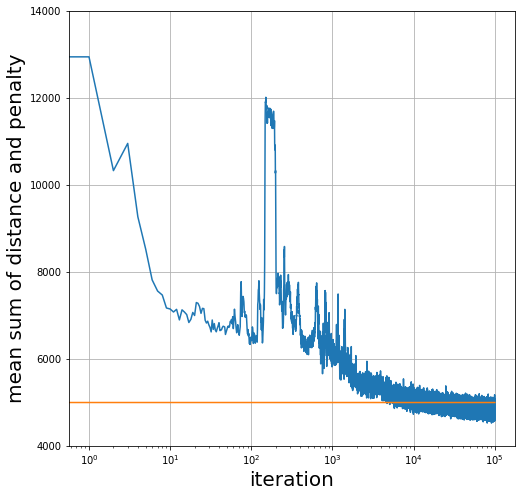

In [9]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.plot(np.ones(len(reward))*5000, )
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
plt.ylim([4000, 14000])
fig.savefig('reward_20_pdcvrptw.png')

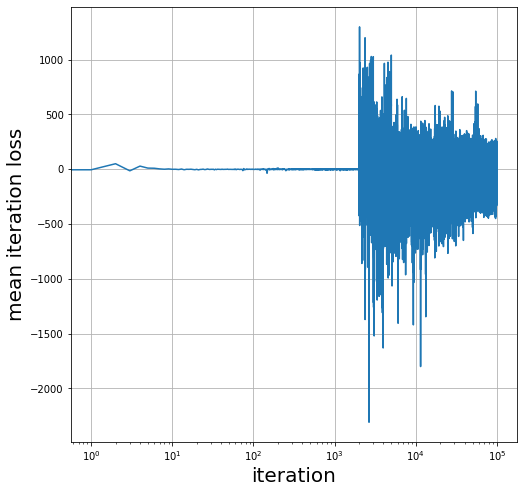

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_15_04_32_07_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.plot(np.ones(len(reward))*5000)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_15_05_17_10_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.plot(np.ones(len(reward))*5000, )
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
model = AttentionModel(active_num=1).to("cuda")
model.load_state_dict(weights)

In [ ]:
model.eval()
print('r')

In [ ]:
%%time
compute_mean_metric(model, device="cuda", n=20, batch_size=1, T=10, sample=True)

In [ ]:
%%time
compute_mean_metric_with_or(model, device="cuda", n=20, batch_size=20, T=1, time_limit=0.5, eps=1e-2)